# Support Vector Regression (SVR) Models

## Libraries

In [99]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')

from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

from scipy.stats import pearsonr

In [ ]:
# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Paths

In [19]:
DATA_ROOT = "./gaitrec_data"
# Train set
UNBALANCED_TRAIN_SET_METADATA_PATH = os.path.join(DATA_ROOT, "unbalanced_train_set_metadata.csv")
POSTPROCESSED_TRAIN_FOLDER = os.path.join(DATA_ROOT, 'postprocessed_train')
GROUPS_SESSIONS_DATA_TRAIN = os.path.join(DATA_ROOT, 'groups_sessions_data_train')
GRF_F_AP_PRO_DATA_TRAIN = os.path.join(DATA_ROOT, 'GRF_F_AP_PRO_data_train')
# Test set
TEST_SET_METADATA_PATH = os.path.join(DATA_ROOT, "test_set_metadata.csv")
TEST_FOLDER = os.path.join(DATA_ROOT, "test_set")
GROUPS_SESSIONS_DATA_TEST = os.path.join(DATA_ROOT, 'groups_sessions_data_test')
GRF_F_AP_PRO_DATA_TEST = os.path.join(DATA_ROOT, 'GRF_F_AP_PRO_data_test')

## Separar las features del target

- Separar las features (valores de la primera sesión) y el target (valores de la última sesión).
- Los valores de la primera sesión corresponden a las filas impares y los valores de la última sesión corresponden a las filas pares. 

In [20]:
def split_df_train_test(df_train: pd.DataFrame, df_test: pd.DataFrame):
    # Select only the columns of interest
    columns_of_interest = df_train.columns[3:]  # Exclude SUBJECT_ID, SESSION_ID, TRIAL_ID
    # Create X_train, y_train, X_test, y_test:
        # Extract the odd rows into X
        # Extract the even rows into y
    X_train = df_train.iloc[::2][columns_of_interest].values
    y_train = df_train.iloc[1::2][columns_of_interest].values
    X_test = df_test.iloc[::2][columns_of_interest].values
    y_test = df_test.iloc[1::2][columns_of_interest].values

    return X_train, y_train, X_test, y_test

## Load preprocessed data
- ANKLE data - 2 sessions

In [21]:
# train df
combined_legs_2sessions_A_train = pd.read_csv(os.path.join(GRF_F_AP_PRO_DATA_TRAIN, 
                              'groups_2sessions_data_train/A_data/combined.csv'))
# test df
combined_legs_2sessions_A_test = pd.read_csv(os.path.join(GRF_F_AP_PRO_DATA_TEST, 
                              'groups_2sessions_data_test/A_data/combined.csv'))

## Train - Test split

In [22]:
# train - test split 
X_train_A2, y_train_A2, X_test_A2, y_test_A2 = split_df_train_test(df_train = combined_legs_2sessions_A_train, 
                                                                   df_test = combined_legs_2sessions_A_test)

## Support Vector Regression

- No todos los algoritmos de regresión admiten la multioutput regression.

- Un ejemplo es el support vector machine, aunque para la regresión, se denomina support vector regression, o SVR.

- Este algoritmo no soporta múltiples salidas para un problema de regresión y dará un error.

### Training Direct Multioutput Regression


https://machinelearningmastery.com/multi-output-regression-models-with-python/ 

- Develop an independent model for each numerical value to be predicted.

- The direct approach to multioutput regression involves dividing the regression problem into a separate problem for each target variable to be predicted.

- This assumes that the outputs are independent of each other, which might not be a correct assumption. Nevertheless, this approach can provide surprisingly effective predictions on a range of problems and may be worth trying, at least as a performance baseline.

- For example, the outputs for your problem may, in fact, be mostly independent, if not completely independent, and this strategy can help you find out.

In [ ]:
def train_and_evaluate_SVR_multioutputregressor(X_train, y_train):
    # Set the random seed for reproducibility
    np.random.seed(42)

    # Define the parameter grid for hyperparameter tuning
    param_dist = {
        'estimator__C': np.logspace(-3, 3, num=10),  # Regularization parameter
        'estimator__epsilon': np.logspace(-4, 2, 7), # Epsilon parameter
        'estimator__kernel':['linear', 'poly', 'rbf', 'sigmoid'],
        'estimator__gamma': ['scale', 'auto'], # np.logspace(-3, 3, 7),
        'estimator__degree': [2, 3, 4, 5]
    }

    # Create a SVR 
    linear_svr = SVR()

    # Create a MultiOutputRegressor with the SVR
    multioutput_linear_svr = MultiOutputRegressor(linear_svr)

    # Create RandomizedSearchCV object with 5-fold cross-validation
    random_search = RandomizedSearchCV(estimator=multioutput_linear_svr,
                                       param_distributions=param_dist,
                                       cv=5,
                                       n_iter=10,
                                       scoring=make_scorer(mean_squared_error, squared=False, greater_is_better=False),
                                       n_jobs=-1)

    # Fit the RandomizedSearchCV object on the training data
    random_search.fit(X_train, y_train)

    # Get the best hyperparameters
    best_params = random_search.best_params_
    print("Best Hyperparameters:", best_params)

    # Get the best SVR model
    best_multioutput_linear_svr = random_search.best_estimator_

    # Perform cross-validation and get predicted values
    predicted_y = cross_val_predict(best_multioutput_linear_svr, X_train, y_train, cv=10)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_train, predicted_y))

    # Calculate R2 score
    r2 = r2_score(y_train, predicted_y)

    # Calculate Correlation Coefficient
    corr_coeff, _ = pearsonr(y_train.flatten(), predictions.flatten())


    # Print the results
    print("Results on Training Set:")
    print(f" RMSE: {rmse:.3f}")
    print(f" R2 Score: {r2:.3f}")
    print(f" Correlation coefficient: {corr_coeff:.3f}")

    return best_multioutput_linear_svr, rmse, r2, corr_coeff

1) 'estimator__C': np.logspace(-3, 3, num=10),  # Regularization parameter
'estimator__epsilon': [0.1, 0.01, 0.001],    # Epsilon parameter
Best Hyperparameters: {'estimator__epsilon': 0.001, 'estimator__C': 0.46415888336127775}
Results on Training Set:
RMSE: 0.015
R2 Score: 0.601


2) Define the parameter grid for hyperparameter tuning
    param_dist = {
        'estimator__C': np.logspace(-3, 3, 7),  # Regularization parameter
        'estimator__epsilon': np.logspace(-4, 2, 7),#[0.1, 0.01, 0.001],    # Epsilon parameter
        'estimator__kernel':['linear', 'poly', 'rbf', 'sigmoid']
    }
Best Hyperparameters: {'estimator__kernel': 'rbf', 'estimator__epsilon': 0.01, 'estimator__C': 0.1}
Results on Training Set:
RMSE: 0.015
R2 Score: 0.562
Correlation coefficient: 0.982

3) param_dist = {
        'estimator__C': np.logspace(-3, 3, 7),  # Regularization parameter
        'estimator__epsilon': np.logspace(-4, 2, 7), #[0.1, 0.01, 0.001],    # Epsilon parameter
        'estimator__kernel':['linear', 'poly', 'rbf', 'sigmoid'],
        'estimator__gamma': np.logspace(-3, 3, 7),
        'estimator__degree': [2, 3, 4, 5] }
Best Hyperparameters: {'estimator__kernel': 'linear', 'estimator__gamma': 100.0, 'estimator__epsilon': 0.001, 'estimator__degree': 5, 'estimator__C': 10.0}
Results on Training Set:
RMSE: 0.016
R2 Score: 0.580
Correlation coefficient: 0.982

4) param_dist = {
        'estimator__C': np.logspace(-3, 3, 7), 
        'estimator__epsilon': np.logspace(-4, 2, 7),
        'estimator__kernel':['linear', 'poly', 'rbf', 'sigmoid'],
        'estimator__gamma': ['scale', 'auto'],
        'estimator__degree': [2, 3, 4, 5]
    }
Best Hyperparameters: {'estimator__kernel': 'rbf', 'estimator__gamma': 'auto', 'estimator__epsilon': 0.0001, 'estimator__degree': 2, 'estimator__C': 100.0}
Results on Training Set:
RMSE: 0.015
R2 Score: 0.591
Correlation coefficient: 0.982

5) param_dist = {
        'estimator__C': np.logspace(-3, 3, num=10),  # Regularization parameter
        'estimator__epsilon': np.logspace(-4, 2, 7), # Epsilon parameter
        'estimator__kernel':['linear', 'poly', 'rbf', 'sigmoid'],
        'estimator__gamma': ['scale', 'auto'], # np.logspace(-3, 3, 7),
        'estimator__degree': [2, 3, 4, 5]
    }
Best Hyperparameters: {'estimator__kernel': 'rbf', 'estimator__gamma': 'auto', 'estimator__epsilon': 0.001, 'estimator__degree': 3, 'estimator__C': 46.41588833612773}
Results on Training Set:
RMSE: 0.015
R2 Score: 0.598
Correlation coefficient: 0.982


### Training Chained Multioutput Regression


https://machinelearningmastery.com/multi-output-regression-models-with-python/

- Another approach to using single-output regression models for multioutput regression is to create a linear sequence of models.

- The first model in the sequence uses the input and predicts one output; the second model uses the input and the output from the first model to make a prediction; the third model uses the input and output from the first two models to make a prediction, and so on.

- For example, if a multioutput regression problem required the prediction of three values y1, y2 and y3 given an input X, then this could be partitioned into three dependent single-output regression problems as follows:

    - Problem 1: Given X, predict y1.
    - Problem 2: Given X and yhat1, predict y2.
    - Problem 3: Given X, yhat1, and yhat2, predict y3.
    - This can be achieved using the RegressorChain class in the scikit-learn library.

- The order of the models may be based on the order of the outputs in the dataset (the default) or specified via the “order” argument. For example, order=[0,1] would first predict the oth output, then the 1st output, whereas an order=[1,0] would first predict the last output variable and then the first output variable in our test problem.

In [117]:
from sklearn.multioutput import RegressorChain
from scipy.stats import loguniform

def train_and_evaluate_chained_svr(X_train, y_train):
    # Set the random seed for reproducibility
    np.random.seed(42)

    # Define the custom order for the chain
    # This order will be determined based on the number of outputs (101 in our case)
    custom_order = list(range(y_train.shape[1]))  # [0, 1, 2, ..., 100]

    # Define the parameter grid for hyperparameter tuning
    param_dist = {
        'base_estimator__C': np.logspace(-3, 3, num=10),  # Regularization parameter
        'base_estimator__epsilon': np.logspace(-4, 2, 7), # Epsilon parameter
        'base_estimator__kernel':['linear', 'poly', 'rbf', 'sigmoid'],
        'base_estimator__gamma': ['scale', 'auto'], # np.logspace(-3, 3, 7),
        'base_estimator__degree': [2, 3, 4, 5]
    }

    # Create an SVR
    svr = SVR()

    # Create a Chained Multioutput Regressor with the SVR
    chained_svr = RegressorChain(base_estimator = svr, order  = custom_order)

    # Create RandomizedSearchCV object with 5-fold cross-validation
    random_search = RandomizedSearchCV(estimator=chained_svr,
                                       param_distributions=param_dist,
                                       cv=5,
                                       n_iter=20,
                                       scoring=make_scorer(mean_squared_error, squared=False, greater_is_better=False),
                                       n_jobs=-1,
                                       random_state=42)

    # Fit the RandomizedSearchCV object on the training data
    random_search.fit(X_train, y_train)

    # Get the best hyperparameters
    best_params = random_search.best_params_
    print("Best Hyperparameters:", best_params)

    # Get the best Chained Multioutput Regressor
    best_chained_svr = random_search.best_estimator_

    # Perform cross-validation and get predicted values
    predicted_y = cross_val_predict(best_chained_svr, X_train, y_train, cv=10)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_train, predicted_y))

    # Calculate R2 score
    r2 = r2_score(y_train, predicted_y)

    # Calculate Correlation Coefficient
    corr_coeff, _ = pearsonr(y_train.flatten(), predictions.flatten())

    # Print the results
    print("Results on Training Set:")
    print(f" RMSE: {rmse:.3f}")
    print(f" R2 Score: {r2:.3f}")
    print(f" Correlation coefficient: {corr_coeff:.3f}")

    return best_chained_svr, rmse, r2, corr_coeff

### Evaluation pipeline 

In [118]:
def evaluate_model_on_test_set(model, X_test, y_test):
    """
    Evaluate the fitted model on the test set.

    Parameters:
        model (PLSRegression): Fitted model.
        X_test (np.ndarray): Test data with shape (num_samples, num_features).
        y_test (np.ndarray): True test target data with shape (num_samples, num_targets).

    Returns:
        List[float]: List of root mean square error (RMSE) scores for each target variable.
        float: Overall root mean square error (RMSE) score averaged across all target variables.
        List[float]: List of correlation coefficients (Pearson's r) for each target variable.
        float: Overall correlation coefficient (Pearson's r) across all target variables.
        List[float]: List of coefficient of determination (R-squared) for each target variable.
        float: Overall coefficient of determination (R-squared) across all target variables.
        List[float]: List of adjusted R-squared for each target variable.
        float: Overall adjusted R-squared across all target variables.
        np.ndarray: Predicted target values for the test set with shape (num_samples, num_targets).
    """
    num_targets = y_test.shape[1]
    rmse_scores_test = []
    correlation_coeffs = []
    coeff_determination_r2 = []
    adj_r_squared = []

    # Apply the dimension reduction learned on the train data.
    y_pred_test = model.predict(X_test)

    for i in range(num_targets):
        y_test_single = y_test[:, i]
        y_pred = y_pred_test[:, i]

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(y_test_single, y_pred)) # this also works: rmse = np.sqrt(np.average((y_test_single - y_pred)**2, axis=0))
        rmse_scores_test.append(rmse)

        # Calculate correlation coefficient (Pearson's r)
        corr_coeff, _ = pearsonr(y_test_single, y_pred)
        correlation_coeffs.append(corr_coeff)

        # Calculate coefficient of determination (R-squared)
        r2 = r2_score(y_test_single, y_pred)
        coeff_determination_r2.append(r2)

        # Calculate adjusted R-squared
        n = len(y_test_single)  # number of samples
        p = X_test.shape[1] - 1  # number of predictors (excluding the constant term)
        adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))  # formula of adjusted R-squared
        adj_r_squared.append(adj_r2)

    # Calculate overall RMSE
    # overall_rmse = np.sqrt(np.mean(np.array(rmse_scores_test) ** 2))
    overall_rmse = mean_squared_error(y_test, y_pred_test, squared=False)

    # Calculate overall correlation coefficient
    overall_corr_coeff, _ = pearsonr(y_test.flatten(), y_pred_test.flatten())

    # Calculate overall coefficient of determination (R-squared)
    overall_coeff_determination_r2 = r2_score(y_test, y_pred_test)

    # Calculate overall adjusted R-squared
    overall_adj_r_squared = 1 - ((1 - overall_coeff_determination_r2) * (len(y_test.flatten()) - 1) / (len(y_test.flatten()) - len(X_test[0]) + 1))

    return rmse_scores_test, overall_rmse, correlation_coeffs, overall_corr_coeff, coeff_determination_r2, overall_coeff_determination_r2, overall_adj_r_squared, y_pred_test


def plot_predictions_vs_true(y_true: np.ndarray, 
                             y_pred: np.ndarray, 
                             rmse_scores_test: list[float],
                             corr_target_test: list[float]) -> None:
    """
    Plot scatter plots of predicted values against true values for each target variable.

    Parameters:
        y_true (np.ndarray): The true target values with shape (n_samples, n_targets).
        y_pred (np.ndarray): The predicted target values with shape (n_samples, n_targets).
        rmse_scores_test (list[float]): List of RMSE scores for each target variable on the test set.
        correlations (list[float]): List of correlation coefficients for each target variable. 

    Returns:
        None
    """
    num_targets = y_true.shape[1]
    num_rows = int(np.ceil(num_targets / 5))
    fig, axes = plt.subplots(num_rows, 5, figsize=(20, 4 * num_rows))
    axes = axes.flatten()

    for target in range(num_targets):
        axes[target].scatter(y_true[:, target], y_pred[:, target], alpha=0.6)
        # the dashed line represents the perfect correlation line between the true and predicted values
        axes[target].plot([y_true[:, target].min(), y_true[:, target].max()],
                          [y_true[:, target].min(), y_true[:, target].max()],
                          color='red', linestyle='dashed')
        axes[target].set_xlabel('True Values')
        axes[target].set_ylabel('Predicted Values')
        axes[target].set_title(f"Target {target + 1}: Predicted vs True Values\nRMSE: {rmse_scores_test[target]:.3f}   Corr: {corr_target_test[target]:.3f}")

    # Hide empty subplots, if any
    for i in range(num_targets, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


from scipy.stats import linregress
def plot_correlation_model(y_true: np.ndarray, 
                           y_pred: np.ndarray, 
                           overall_corr_coeff: float) -> None:
    """
    Create a global correlation plot of the model's predictions with all points and a reference line.

    Parameters:
        y_true (np.ndarray): The true target values with shape (n_samples, n_targets).
        y_pred (np.ndarray): The predicted target values with shape (n_samples, n_targets).
        overall_corr_coeff (float): Overall correlation coefficient (Pearson's r) across all target variables.

    Returns:
        None
    """

    # Flatten the true and predicted values
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Create a scatter plot of true values against predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true_flat, y_pred_flat, alpha=0.7)

    # # Calculate the linear regression line parameters
    # slope, intercept, r_value, p_value, std_err = linregress(y_true_flat, y_pred_flat)
    # line = slope * y_true_flat + intercept
    # # Plot the linear regression line
    # plt.plot(y_true_flat, line, color='red', label='Regression Line')

    # Plot the reference line for perfect correlation:
    """
    The red line in the scatter plot is a reference line that represents a perfect correlation 
    between the true values and the predicted values. In other words, if all the data points were exactly 
    on this line, it would mean that the predicted values perfectly match the true values. 
    The slope of this line is 1, and it passes through the origin (0,0)."
    """
    plt.plot(y_true_flat, y_true_flat, color='red', linestyle='-', label='Perfect Correlation Line')


    # Add labels and title
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('Correlation Plot of Model Predictions')

    # Annotate the overall correlation coefficient on the plot
    plt.text(0.02, 0.9, f'Overall Correlation (Pearson r = {overall_corr_coeff:.3f})', transform=plt.gca().transAxes, 
             fontsize=11, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.8))

    # Add legend with Perfect Correlation Line
    plt.legend(loc='best')

    plt.show()

def plot_last_session_mean_prediction_vs_mean_true(y_true: np.ndarray, 
                                                   y_pred: np.ndarray, 
                                                   overall_rmse: float,
                                                   overall_corr: float,
                                                   overall_r2: float,
                                                   overall_adj_r2: float,
                                                   time_points: int = 101,
                                                   x_ticks: int = 10) -> None:
    """
    Plot mean prediction values against mean true values for each target variable.

    Parameters:
        y_true (np.ndarray): The true target values with shape (n_samples, n_targets).
        y_pred (np.ndarray): The predicted target values with shape (n_samples, n_targets).
        overall_rmse (float): The overall root mean square error (RMSE) of the model.
        overall_corr (float): The overall correlation coefficient of the model.
        overall_r2 (float): The overall coefficient of determination (R-squared) of the model.
        overall_adj_r2 (float): The overall adjusted R-squared of the model.
        time_points (int): Number of time points.
        x_ticks (int): Interval for x-axis ticks.

    Returns:
        None
    """
    # Create the x-axis with values from 0 to 100 (time points)
    x_axis = [str(num) for num in range(time_points)]

    # Calculate mean values for predictions and true values across all patients for each target variable
    mean_y_pred = np.mean(y_pred, axis=0)
    mean_y_true = np.mean(y_true, axis=0)

    # Plot the lines
    plt.figure(figsize=(12, 6))
    plt.plot(x_axis, mean_y_pred, label='Last Session Mean Prediction')
    plt.plot(x_axis, mean_y_true, label='Last Session Mean True')

    # Add overall RMSE, overall correlation and overall R2 as text in the plot
    plt.text(0.75, 0.31, f"RMSE: {overall_rmse:.3f}", transform=plt.gca().transAxes,
             fontsize=11, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.8))
    
    plt.text(0.75, 0.25, f"Correlation: {overall_corr:.3f}", transform=plt.gca().transAxes,
             fontsize=11, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.8))

    plt.text(0.75, 0.19, f"R-squared: {overall_r2:.3f}", transform=plt.gca().transAxes,
             fontsize=11, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.8))
    
    plt.text(0.75, 0.13, f"Adj. R-squared: {overall_adj_r2:.3f}", transform=plt.gca().transAxes,
             fontsize=11, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.8))
             
    # Add labels and title
    plt.xlabel('Stance (%)')
    plt.ylabel('Body weight (%)')
    plt.title('Last Session Mean Prediction vs Last Session Mean True')

    # Customize x-axis ticks and labels
    x_ticks = range(0, len(x_axis), x_ticks)
    x_tick_labels = [x_axis[i] for i in x_ticks]
    plt.xticks(x_ticks, x_tick_labels)

    # Add legend for mean and standard deviation
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


def calculate_HC_mean(group:str, num_sessions: int = 2):
    # Session folder
    session_folder = os.path.join(GROUPS_SESSIONS_DATA_TRAIN, f'groups_{num_sessions}sessions_data_train')

    # Group folders
    hc_folder = os.path.join(session_folder, 'HC_data')
    group_folder = os.path.join(session_folder, f'{group}_data')

    # Dictionary to store HC mean lines per common CSV filename
    hc_means = {}

    # Iterate over the CSV files in the HC folder
    for hc_filename in os.listdir(hc_folder):
        if hc_filename.endswith(".csv"):
            # HC file path
            hc_filepath = os.path.join(hc_folder, hc_filename)
            # Read the HC CSV file
            hc_df = pd.read_csv(hc_filepath)
            # Extract common filename part
            common_filename = hc_filename.split("_train_")[0]
            # Calculate mean line of HC and store it in the dictionary
            hc_means[common_filename] = np.mean(hc_df.iloc[:, 3:].values, axis=0)

    return hc_means[common_filename]


def plot_system_output(hc_means: np.ndarray,
                       first_session: np.ndarray, # 1st session (X_test)
                       y_true: np.ndarray, # last session true
                       y_pred: np.ndarray,# last session pred
                       overall_rmse: float,
                       overall_corr: float, 
                       overall_r2: float,
                       overall_adj_r2: float,
                       time_points: int = 101,
                       x_ticks: int = 10,
                       text_x: float = 0.75,
                       text_y: float = 0.31) -> None:
    """
    Plot mean prediction values against mean true values for each target variable.

    Parameters:
        hc_means (np.ndarray): The mean values of healthy controls for each target variable.
        first_session (np.ndarray): The mean values of the first session for each target variable.
        y_true (np.ndarray): The true target values with shape (n_samples, n_targets).
        y_pred (np.ndarray): The predicted target values with shape (n_samples, n_targets).
        overall_rmse (float): The overall root mean square error (RMSE) of the model.
        overall_corr (float): The overall correlation coefficient of the model.
        overall_r2 (float): The overall coefficient of determination (R-squared) of the model.
        overall_adj_r2 (float): The overall adjusted R-squared of the model.
        time_points (int): Number of time points.
        x_ticks (int): Interval for x-axis ticks.
        text_x (float): The position to place the text (x axis). By default, this is in data coordinates. % of the width of the axes
        text_y (float): The position to place the text (y axis). By default, this is in data coordinates. % of the height of the axes.

    Returns:
        None
    """
    # Create the x-axis with values from 0 to 100 (time points)
    x_axis = [str(num) for num in range(time_points)]

    # Calculate mean values for predictions and true values across all patients for each target variable
    mean_first_session = np.mean(first_session, axis=0)
    mean_y_pred = np.mean(y_pred, axis=0)
    mean_y_true = np.mean(y_true, axis=0)

    # Plot the lines
    plt.figure(figsize=(12, 6))
    plt.plot(x_axis, hc_means, label='HC Mean', color='black')
    plt.plot(x_axis, mean_first_session, label='First Session Mean', color='red')
    plt.plot(x_axis, mean_y_true, label='Last Session Mean True', color='green')
    plt.plot(x_axis, mean_y_pred, label='Last Session Mean Prediction', color='blue')

    # # Add overall RMSE, overall correlation and overall R2 as text in the plot
    # plt.text(0.75, 0.31, f"RMSE: {overall_rmse:.3f}", transform=plt.gca().transAxes,
    #          fontsize=11, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.8))
    
    # plt.text(0.75, 0.25, f"Correlation: {overall_corr:.3f}", transform=plt.gca().transAxes,
    #          fontsize=11, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.8))

    # plt.text(0.75, 0.19, f"R-squared: {overall_r2:.3f}", transform=plt.gca().transAxes,
    #          fontsize=11, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.8))
    
    # plt.text(0.75, 0.13, f"Adj. R-squared: {overall_adj_r2:.3f}", transform=plt.gca().transAxes,
    #         fontsize=11, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.8))
    
    # Add overall RMSE, overall correlation and overall R2 as text in the plot
    # Concatenate the strings for all the metrics
    metrics_text = f"RMSE: {overall_rmse:.3f}\n"
    metrics_text += f"Correlation: {overall_corr:.3f}\n"
    metrics_text += f"R-squared: {overall_r2:.3f}\n"
    metrics_text += f"Adj. R-squared: {overall_adj_r2:.3f}"

    # Add the concatenated text as a single text box in the plot
    plt.text(text_x, text_y, metrics_text, transform=plt.gca().transAxes,
            fontsize=11, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.8))

    # Add labels and title
    plt.xlabel('Stance (%)')
    plt.ylabel('Body weight (%)')
    plt.title('HC mean vs 1st Session Mean vs Last Session Mean True vs Last Session Mean Prediction')

    # Customize x-axis ticks and labels
    x_ticks = range(0, len(x_axis), x_ticks)
    x_tick_labels = [x_axis[i] for i in x_ticks]
    plt.xticks(x_ticks, x_tick_labels)

    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


from matplotlib.collections import LineCollection

def plot_last_session_mean_prediction_with_rmse(y_true: np.ndarray, 
                                                y_pred: np.ndarray, 
                                                rmse_scores_test: list[float],
                                                time_points: int = 101,
                                                x_ticks: int = 10) -> None:
    """
    Plot mean prediction values against mean true values for each target variable with RMSE color encoding.

    Parameters:
        y_true (np.ndarray): The true target values with shape (n_samples, n_targets).
        y_pred (np.ndarray): The predicted target values with shape (n_samples, n_targets).
        rmse_scores_test (list[float]): List of RMSE scores for each target variable on the test set.
        time_points (int): Number of time points.
        x_ticks (int): Interval for x-axis ticks.

    Returns:
        None
    """

    # Create the x-axis with values from 0 to 100 (time points)
    x_axis = np.arange(0, time_points)

    # Calculate mean values for predictions and true values across all patients for each target variable
    mean_y_pred = np.mean(y_pred, axis=0)
    mean_y_true = np.mean(y_true, axis=0)

    # Create colormap for RMSE values
    colormap =  plt.colormaps.get_cmap('coolwarm')


    # Create line segments for LineCollection
    segments = np.stack((x_axis, mean_y_pred), axis=-1)
    segments = [[[x0, y0], [x1, y1]] for (x0, y0), (x1, y1) in zip(segments[:-1], segments[1:])]

    # Create LineCollection with RMSE color encoding
    lc = LineCollection(segments, 
                        cmap=colormap, 
                        norm=plt.Normalize(vmin=min(rmse_scores_test), 
                                           vmax=max(rmse_scores_test)), 
                        linewidth=3)
    lc.set_array(np.array(rmse_scores_test))

    # Plot the LineCollection
    plt.figure(figsize=(12, 6))
    plt.gca().add_collection(lc)
    plt.gca().autoscale()
    
    # Add colorbar for RMSE values
    cbar = plt.colorbar(lc, label='RMSE')

    # Add labels and title
    plt.xlabel('Stance (%)')
    plt.ylabel('Body weight (%)')
    plt.title('Last Session Mean Prediction with RMSE Color Encoding')

    # Customize x-axis ticks and labels
    x_ticks = np.arange(0, time_points, x_ticks)
    x_tick_labels = [str(num) for num in x_ticks]
    plt.xticks(x_ticks, x_tick_labels)

    # Add legend for target variables
    #plt.legend(loc='best')
    plt.grid(True)
    plt.show()


def plot_last_session_mean_prediction_with_corr(y_true: np.ndarray, 
                                                y_pred: np.ndarray, 
                                                corr_target_test: list[float],
                                                time_points: int = 101,
                                                x_ticks: int = 10) -> None:
    """
    Plot mean prediction values against mean true values for each target variable with correlation coefficient color encoding.

    Parameters:
        y_true (np.ndarray): The true target values with shape (n_samples, n_targets).
        y_pred (np.ndarray): The predicted target values with shape (n_samples, n_targets).
        corr_target_test (list[float]): List of correlation coefficients for each target variable. 
        time_points (int): Number of time points.
        x_ticks (int): Interval for x-axis ticks.

    Returns:
        None
    """

    # Create the x-axis with values from 0 to 100 (time points)
    x_axis = np.arange(0, time_points)

    # Calculate mean values for predictions and true values across all patients for each target variable
    mean_y_pred = np.mean(y_pred, axis=0)
    mean_y_true = np.mean(y_true, axis=0)

    # Create colormap for correlation coefficients
    colormap =  plt.colormaps.get_cmap('coolwarm')


    # Create line segments for LineCollection
    segments = np.stack((x_axis, mean_y_pred), axis=-1)
    segments = [[[x0, y0], [x1, y1]] for (x0, y0), (x1, y1) in zip(segments[:-1], segments[1:])]

    # Create LineCollection with orrelation coefficient color encoding
    lc = LineCollection(segments, 
                        cmap=colormap, 
                        norm=plt.Normalize(vmin=min(corr_target_test), 
                                           vmax=max(corr_target_test)), 
                        linewidth=3)
    lc.set_array(np.array(corr_target_test))

    # Plot the LineCollection
    plt.figure(figsize=(12, 6))
    plt.gca().add_collection(lc)
    plt.gca().autoscale()
    
    # Add colorbar for correlation coefficient values
    cbar = plt.colorbar(lc, label='Correlation Coefficient')

    # Add labels and title
    plt.xlabel('Stance (%)')
    plt.ylabel('Body weight (%)')
    plt.title('Last Session Mean Prediction with Correlation Coefficient Color Encoding')

    # Customize x-axis ticks and labels
    x_ticks = np.arange(0, time_points, x_ticks)
    x_tick_labels = [str(num) for num in x_ticks]
    plt.xticks(x_ticks, x_tick_labels)

    # Add legend for target variables
    #plt.legend(loc='best')
    plt.grid(True)
    plt.show()

def plot_last_session_mean_prediction_with_r2(y_true: np.ndarray, 
                                            y_pred: np.ndarray, 
                                            r_squared: list[float],
                                            time_points: int = 101,
                                            x_ticks: int = 10) -> None:
    """
    Plot mean prediction values against mean true values for each target variable with correlation coefficient color encoding.

    Parameters:
        y_true (np.ndarray): The true target values with shape (n_samples, n_targets).
        y_pred (np.ndarray): The predicted target values with shape (n_samples, n_targets).
        corr_target_test (list[float]): List of correlation coefficients for each target variable. 
        time_points (int): Number of time points.
        x_ticks (int): Interval for x-axis ticks.

    Returns:
        None
    """

    # Create the x-axis with values from 0 to 100 (time points)
    x_axis = np.arange(0, time_points)

    # Calculate mean values for predictions and true values across all patients for each target variable
    mean_y_pred = np.mean(y_pred, axis=0)
    mean_y_true = np.mean(y_true, axis=0)

    # Create colormap for correlation coefficients
    colormap =  plt.colormaps.get_cmap('coolwarm')


    # Create line segments for LineCollection
    segments = np.stack((x_axis, mean_y_pred), axis=-1)
    segments = [[[x0, y0], [x1, y1]] for (x0, y0), (x1, y1) in zip(segments[:-1], segments[1:])]

    # Create LineCollection with orrelation coefficient color encoding
    lc = LineCollection(segments, 
                        cmap=colormap, 
                        norm=plt.Normalize(vmin=min(r_squared), 
                                           vmax=max(r_squared)), 
                        linewidth=3)
    lc.set_array(np.array(r_squared))

    # Plot the LineCollection
    plt.figure(figsize=(12, 6))
    plt.gca().add_collection(lc)
    plt.gca().autoscale()
    
    # Add colorbar for correlation coefficient values
    cbar = plt.colorbar(lc, label='R-squared')

    # Add labels and title
    plt.xlabel('Stance (%)')
    plt.ylabel('Body weight (%)')
    plt.title('Last Session Mean Prediction with R-squared Color Encoding')

    # Customize x-axis ticks and labels
    x_ticks = np.arange(0, time_points, x_ticks)
    x_tick_labels = [str(num) for num in x_ticks]
    plt.xticks(x_ticks, x_tick_labels)

    # Add legend for target variables
    #plt.legend(loc='best')
    plt.grid(True)
    plt.show()

## Model 18: SVR

### Training 

In [102]:
# Model 18 (direct multioutput regression SVR) training and evaluation on the train set
svr_model_14, rmse_svr14, r2_svr14, corr_svr14 = train_and_evaluate_SVR_multioutputregressor(X_train = X_train_A2, 
                                                                                             y_train = y_train_A2)

Best Hyperparameters: {'estimator__kernel': 'rbf', 'estimator__gamma': 'auto', 'estimator__epsilon': 0.001, 'estimator__degree': 3, 'estimator__C': 46.41588833612773}
Results on Training Set:
 RMSE: 0.015
 R2 Score: 0.598
 Correlation coefficient: 0.982


In [115]:
# Model 18_chained (chained multioutput SVR) training and evaluation on the train set
chained_svr_model, rmse_chained_svr, r2_chained_svr, corr_coeff_chained_svr = train_and_evaluate_chained_svr(X_train = X_train_A2, 
                                                                                                             y_train = y_train_A2)


Best Hyperparameters: {'base_estimator__kernel': 'rbf', 'base_estimator__gamma': 'auto', 'base_estimator__epsilon': 0.001, 'base_estimator__degree': 3, 'base_estimator__C': 46.41588833612773}
Results on Training Set:
 RMSE: 0.015
 R2 Score: 0.593
 Correlation coefficient: 0.982


#### Evaluation

In [119]:
# Model 18 (direct multioutput regression SVR) evaluation on the test set
rmse_scores_test_A2, overall_rmse_test_A2, corr_target_test_A2, overall_corr_test_A2, \
R2_target_test_A2, overall_R2_test_A2, overall_adj_R2_test_A2, \
y_pred_test_A2 = evaluate_model_on_test_set(
    model=svr_model_14, 
    X_test=X_test_A2, 
    y_test=y_test_A2)

print("Results on Test Set:")
print(f" Overall RMSE: {overall_rmse_test_A2:.3f}")
print(f" Overall Correlation Coefficient: {overall_corr_test_A2:.3f}")
print(f" Overall R-squared: {overall_R2_test_A2:.3f}")
print(f" Overall Adjusted R-squared: {overall_adj_R2_test_A2:.3f}")

Results on Test Set:
 Overall RMSE: 0.014
 Overall Correlation Coefficient: 0.989
 Overall R-squared: 0.509
 Overall Adjusted R-squared: 0.498


In [116]:
# Model 18_chained (chained multioutput SVR) evaluation on the test set
rmse_scores_test_A2_chained_svr, overall_rmse_test_A2_chained_svr, corr_target_test_A2_chained_svr, overall_corr_test_A2_chained_svr, \
R2_target_test_A2_chained_svr, overall_R2_test_A2_chained_svr, overall_adj_R2_test_A2_chained_svr, \
y_pred_test_A2_chained_svr = evaluate_model_on_test_set(
    model=chained_svr_model, 
    X_test=X_test_A2, 
    y_test=y_test_A2)

print("Results on Test Set:")
print(f" Overall RMSE: {overall_rmse_test_A2_chained_svr:.3f}")
print(f" Overall Correlation Coefficient: {overall_corr_test_A2_chained_svr:.3f}")
print(f" Overall R-squared: {overall_R2_test_A2_chained_svr:.3f}")
print(f" Overall Adjusted R-squared: {overall_adj_R2_test_A2_chained_svr:.3f}")

Results on Test Set:
 Overall RMSE: 0.014
 Overall Correlation Coefficient: 0.989
 Overall R-squared: 0.491
 Overall Adjusted R-squared: 0.480


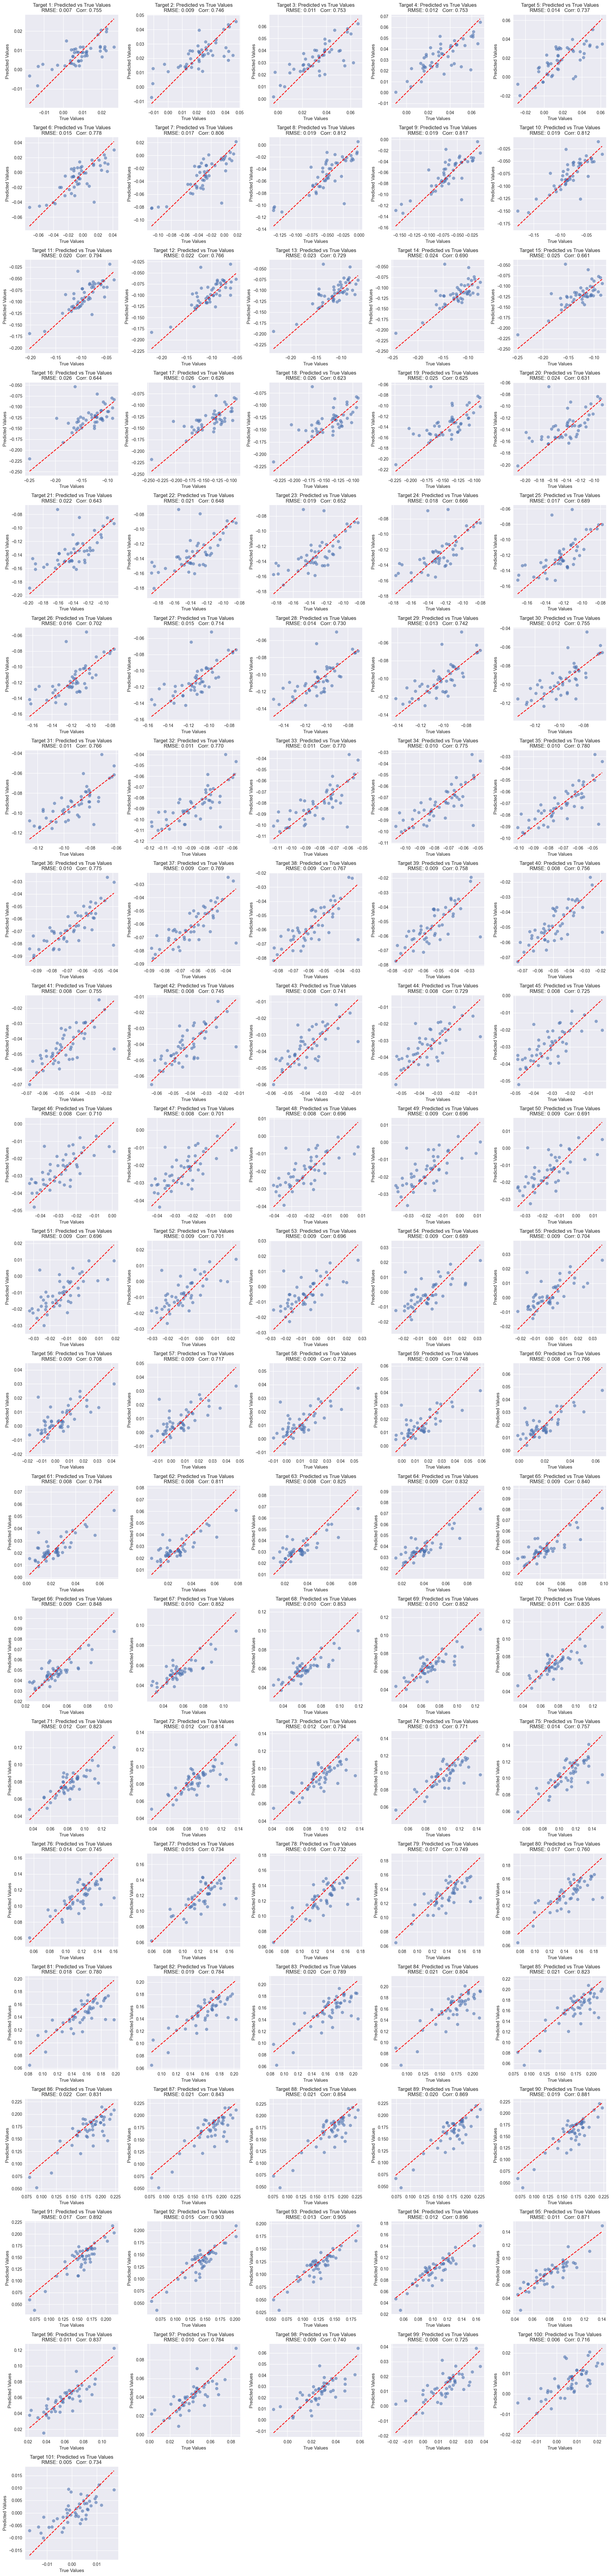

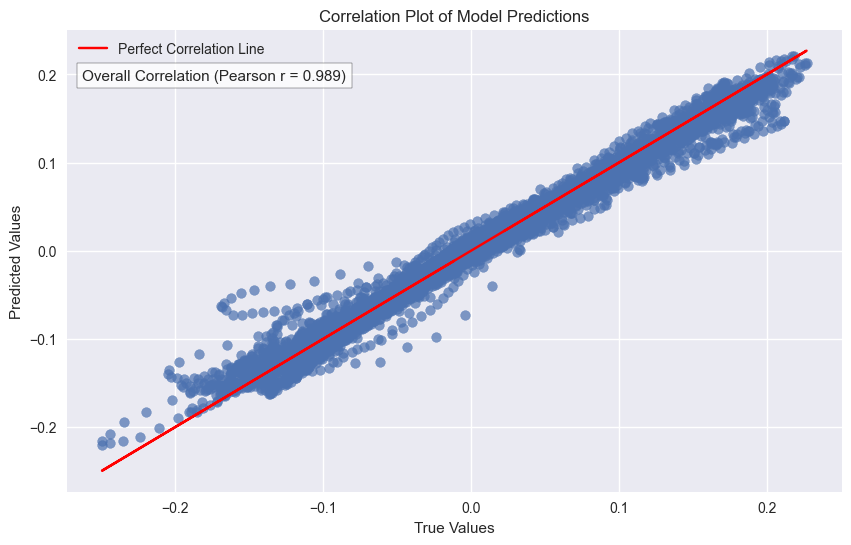

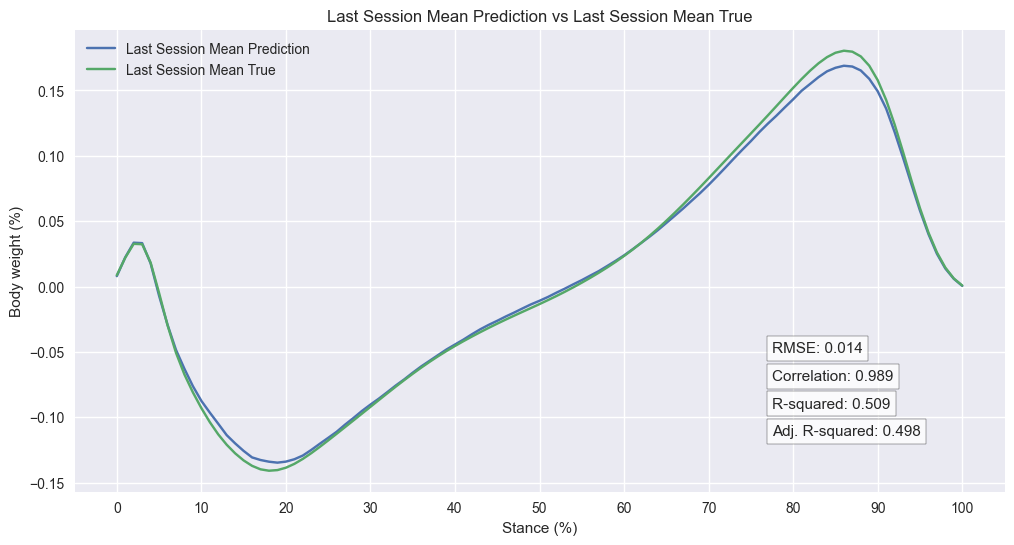

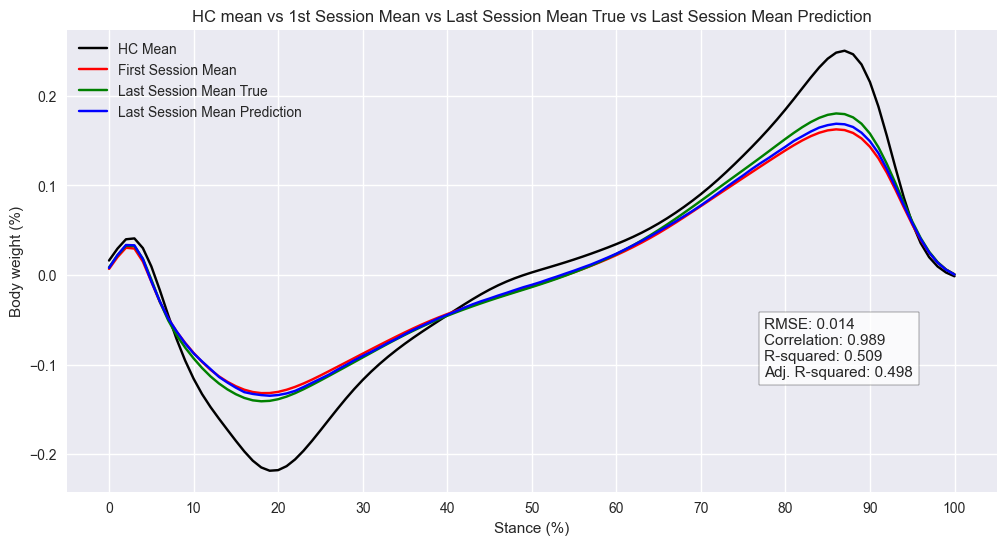

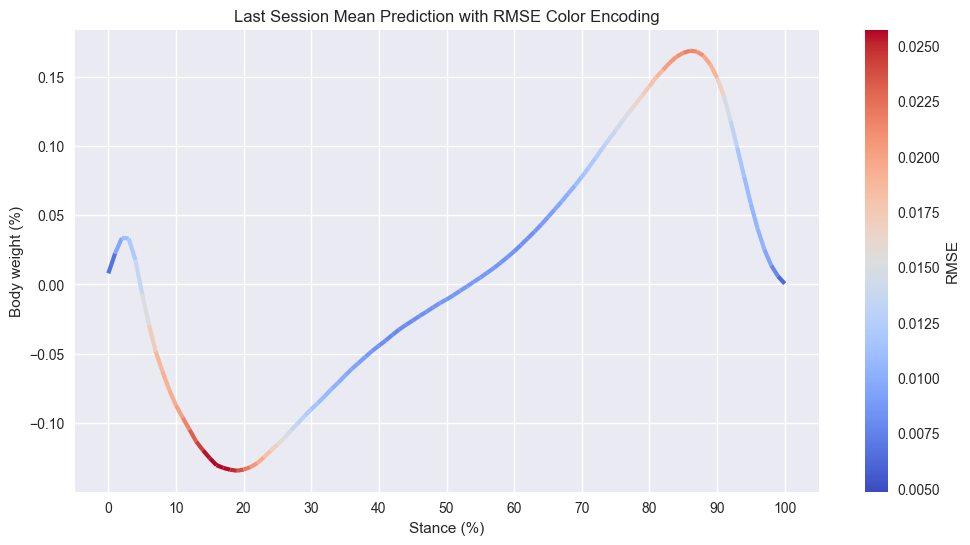

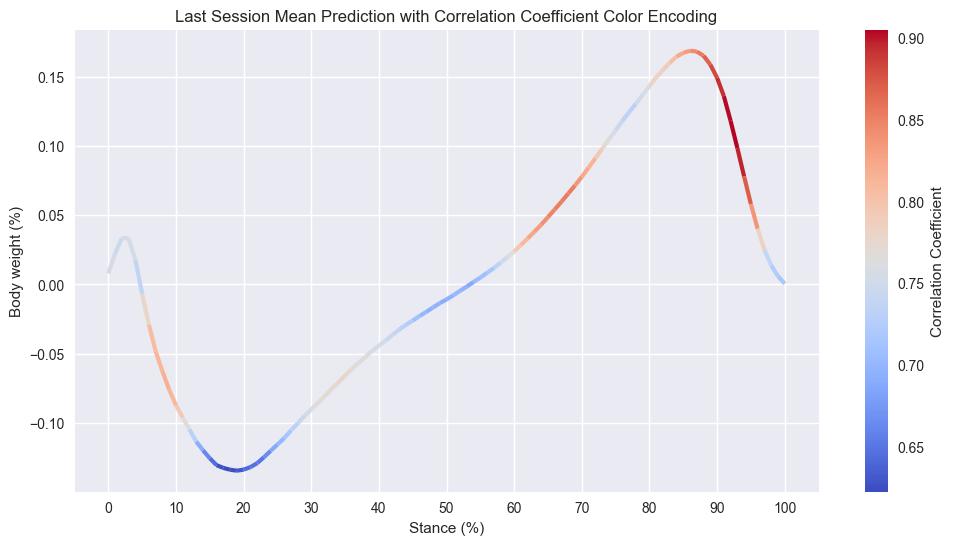

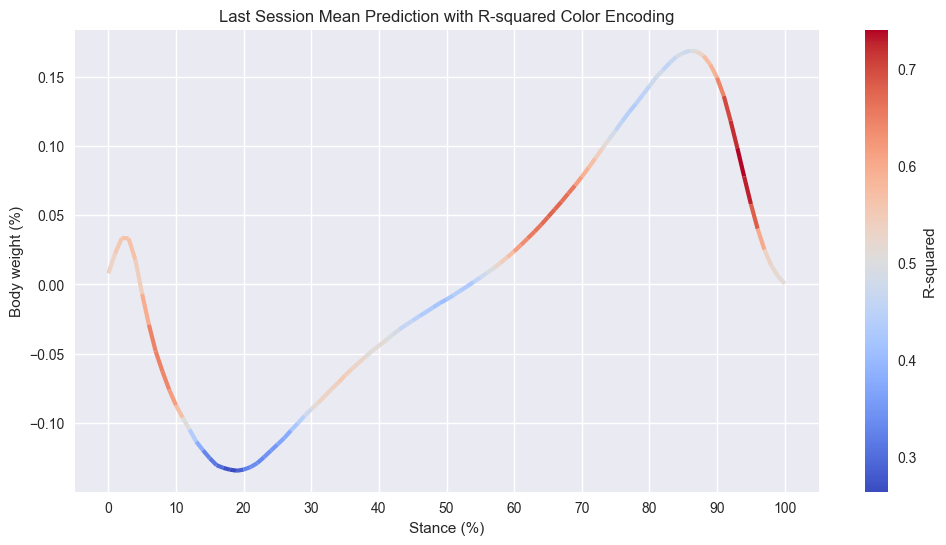

In [120]:
# Model 18 (direct multioutput SVR):
plot_predictions_vs_true(y_true=y_test_A2, 
                         y_pred=y_pred_test_A2, 
                         rmse_scores_test = rmse_scores_test_A2,
                         corr_target_test = corr_target_test_A2)

# Model 18 (direct multioutput SVR): global correlation plot of the model's predictions with all points and the perfect correlation line.
plot_correlation_model(y_true=y_test_A2, y_pred=y_pred_test_A2, overall_corr_coeff=overall_corr_test_A2)

# Model 18 (direct multioutput SVR):
plot_last_session_mean_prediction_vs_mean_true(y_true = y_test_A2, 
                                               y_pred = y_pred_test_A2, 
                                               overall_rmse = overall_rmse_test_A2,
                                               overall_corr = overall_corr_test_A2,
                                               overall_r2 = overall_R2_test_A2,
                                               overall_adj_r2 = overall_adj_R2_test_A2,
                                               time_points = 101,
                                               x_ticks= 10)

# Model 18 (direct multioutput SVR):
plot_system_output(hc_means = calculate_HC_mean(group = 'A', num_sessions = 2), 
                    first_session = X_test_A2, 
                    y_true = y_test_A2, 
                    y_pred = y_pred_test_A2, 
                    overall_rmse = overall_rmse_test_A2,
                    overall_corr = overall_corr_test_A2,
                    overall_r2 = overall_R2_test_A2,
                    overall_adj_r2 = overall_adj_R2_test_A2,
                    time_points = 101)

# Model 18 (direct multioutput SVR): plot last session mean prediction with RMSE color encoding
plot_last_session_mean_prediction_with_rmse(y_true=y_test_A2, 
                                            y_pred=y_pred_test_A2, 
                                            rmse_scores_test=rmse_scores_test_A2,
                                            time_points=101)

# Model 18 (direct multioutput SVR): plot last session mean prediction with correlation coefficient color encoding
plot_last_session_mean_prediction_with_corr(y_true=y_test_A2, 
                                            y_pred=y_pred_test_A2, 
                                            corr_target_test=corr_target_test_A2)
                                                  
# Model 18 (direct multioutput SVR): plot last session mean prediction with R-squared color encoding
plot_last_session_mean_prediction_with_r2(y_true=y_test_A2, 
                                          y_pred=y_pred_test_A2, 
                                          r_squared=R2_target_test_A2)

## Model 15: XGBoost Regressor con PCA de la X (reducida) e Y sin reducir

### PCA de la X

In [ ]:
from sklearn.decomposition import PCA
from typing import Tuple

def apply_pca_to_X(df_train: pd.DataFrame, 
                   X_train: np.ndarray, 
                   X_test: np.ndarray, 
                   variance_retained: float) -> Tuple[np.ndarray, np.ndarray, pd.DataFrame]:
    """
    Apply Principal Component Analysis (PCA) to reduce the dimensionality of the feature set.

    Parameters:
        df_train (pd.DataFrame): The DataFrame containing the training data, including features and target variables.
        X_train (np.ndarray): The training data with shape (num_samples, num_features).
        X_test (np.ndarray): The test data with shape (num_samples, num_features).
        variance_retained (float): The minimum percentage of variance to be retained. A value between 0 and 1.

    Returns:
        Tuple[np.ndarray, np.ndarray, pd.DataFrame]: A tuple containing:
            - Reduced training data with shape (num_samples, n_components), where n_components is determined by PCA.
            - Reduced test data with shape (num_samples, n_components), where n_components is determined by PCA.
            - DataFrame containing the loadings for each principal component.

    Notes:
        - This function applies PCA to reduce the dimensionality of the feature set (X_train and X_test).
        - The provided df_train should include columns of interest for features and target variables.
        - The variance_retained parameter specifies the minimum percentage of variance to be retained.
        - The function returns the reduced training and test data and the loadings for each principal component.

    Example:
        X_train_reduced, X_test_reduced, loadings = apply_pca(df_train, X_train, X_test, variance_retained=0.9)
    """
    df_train = df_train
    columns_of_interest = df_train.columns[3:]  # Exclude SUBJECT_ID, SESSION_ID, TRIAL_ID
    X_train_df = df_train.iloc[::2][columns_of_interest]

    # Standardize the features (scale the data)
    """
    Ajustar (Fit) StandardScaler solo a train features:
        Al ajustar el scaler al conjunto de entrenamiento y utilizarlo para transformar el conjunto de prueba, 
        se garantiza que los factores de escalado se aprenden del conjunto de entrenamiento y no se ven 
        influidos por por el conjunto de prueba. Esto evita la fuga de datos y garantiza que las estimaciones 
        de rendimiento del modelo en el conjunto de prueba no esté sesgada.
        Si ajustamos el scaler a los conjuntos de validación o de prueba y lo utilizamos para transformar 
        el conjunto de entrenamiento, el conjunto de entrenamiento se escalará utilizando información de 
        los conjuntos de validación o de prueba, lo que no es deseable. 
        Esto puede llevar a un sobreajuste del conjunto de entrenamiento y a un pobre rendimiento 
        de la generalización en los nuevos datos.  
    """
    # scaler = StandardScaler()
    # X_train_std = scaler.fit_transform(X_train)
    # X_test_std = scaler.transform(X_test)

    # Apply PCA
    pca = PCA(n_components=variance_retained)
    X_train_reduced = pca.fit_transform(X_train) # X_train_std
    X_test_reduced = pca.transform(X_test) # X_test_std

    # Get the number of components selected to explain the specified variance
    n_components = pca.n_components_
    print(f"Number of components selected by PCA to explain at least {variance_retained*100:.0f}% of the variance: {n_components}")

    # Calculate the variance explained by each component
    variance = pd.DataFrame({'variance': pca.explained_variance_ratio_*100,
                             'PC': ['PC{}'.format(i) for i in range(1, n_components+1)]})
    variance = variance.sort_values('variance', ascending=False)

    # Plot the variance explained by each component
    sns.barplot(x='PC', y='variance', data=variance, color='blue')
    plt.title('Variance explained by each principal component')
    plt.xlabel('Principal Component')
    plt.ylabel('Percentage of explained variances') 
    plt.show()

    # Get the loadings for each component
    loadings = pd.DataFrame(pca.components_.T, columns=['PC{}'.format(i) for i in range(1, n_components+1)], index=X_train_df.columns)

    # Plot the loadings for each principal component
    n_rows = (n_components + 1) // 2
    fig, axs = plt.subplots(n_rows, 
                            2, 
                            figsize=(20, 22 * n_rows), 
                            sharey=False, 
                            gridspec_kw={'hspace': 0.1, 'wspace': 0.2})
    
    for i in range(n_components):
        row = i // 2
        col = i % 2
        loadings_pc = loadings[f'PC{i+1}'].abs().sort_values(ascending=False)
        sns.barplot(x=loadings_pc.values, 
                    y=loadings_pc.index, 
                    ax=axs[row, col], 
                    color='blue', 
                    order=loadings_pc.index)
        axs[row, col].set_title(f'Loadings for PC{i+1}')
        axs[row, col].set_xlabel('Loading Value')
        axs[row, col].set_ylabel('Variable')
        
    # Adjust the subplots if n_components is odd to remove an empty subplot
    if n_components % 2 != 0:
        axs[n_rows-1, 1].remove()
    
    # Get the variance explained by each principal component
    explained_variances = pca.explained_variance_ratio_
    # Print the variance explained by each principal component
    total_variance = 0
    for i, variance in enumerate(explained_variances):
        if total_variance <= variance_retained:
            print(f"Varianza Componente {i+1}: {variance}")
            total_variance = total_variance + variance
    print(f"Varianza Acumulada Explicada: {total_variance}")
        
    plt.show()

    return X_train_reduced, X_test_reduced, loadings, n_components

In [ ]:
## Model 15 (XGBoost Regressor) con PCA de la X (reducida) e Y sin reducir
# Apply PCA to reduce the dimensionality of X_train_A2 and X_test_A2
X_train_reduced_A2, X_test_reduced_A2, loadings_A2_X_red, n_components_x = apply_pca_to_X(
                                                                df_train = combined_legs_2sessions_A_train,
                                                                X_train = X_train_A2, 
                                                                X_test = X_test_A2, 
                                                                variance_retained = 0.9)

### Training 

In [ ]:
# Train and evaluate the XGBoost Regressor (model 15) con PCA de la X (reducida) e Y sin reducir
model_results_A2_X_red, rmse_scores_A2_X_red, r2_scores_A2_X_red, corr_scores_A2_X_red = train_and_evaluate_xgbost(X_train = X_train_reduced_A2, 
                                                                                                                   y_train = y_train_A2)

Best Hyperparameters: {'n_estimators': 700, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 25}
Results on Training Set:
 RMSE: 0.018
 R2 Score: 0.405
 Correlation coefficient: 0.981


### Evaluation

In [ ]:
# Model 15 (XGBoost Regressor con PCA de la X (reducida) e Y sin reducir) evaluation on the test set
rmse_scores_test_A2_X_red, overall_rmse_test_A2_X_red, corr_target_test_A2_X_red, overall_corr_test_A2_X_red, \
R2_target_test_A2_X_red, overall_R2_test_A2_X_red, overall_adj_R2_test_A2_X_red, \
y_pred_test_A2_X_red = evaluate_model_on_test_set(model = model_results_A2_X_red, 
                                                  X_test = X_test_reduced_A2, 
                                                  y_test = y_test_A2)

print("Results on Test Set:")
print(f" Overall RMSE: {overall_rmse_test_A2_X_red:.3f}")
print(f" Overall Correlation Coefficient: {overall_corr_test_A2_X_red:.3f}")
print(f" Overall R-squared: {overall_R2_test_A2_X_red:.3f}")
print(f" Overall Adjusted R-squared: {overall_adj_R2_test_A2_X_red:.3f}")

Results on Test Set:
 Overall RMSE: 0.015
 Overall Correlation Coefficient: 0.987
 Overall R-squared: 0.350
 Overall Adjusted R-squared: 0.349


In [ ]:
# Model 14 (XGBoost Regressor):  Plot predictions vs. true values
plot_predictions_vs_true(y_true = y_test_A2, 
                         y_pred = y_pred_test_A2_X_red, 
                         rmse_scores_test = rmse_scores_test_A2_X_red,
                         corr_target_test = corr_target_test_A2_X_red)

# Model 14 (XGBoost Regressor): global correlation plot of the model's predictions with all points and a correlation line.
plot_correlation_model(y_true=y_test_A2, y_pred=y_pred_test_A2_X_red, overall_corr_coeff=overall_corr_test_A2_X_red)

# Gráficas de solapamiento:
# Model 14 (XGBoost Regressor): y_test_A2, y_pred_test_A2_X_red
plot_last_session_mean_prediction_vs_mean_true(y_true=y_test_A2, 
                                               y_pred=y_pred_test_A2_X_red, 
                                               overall_rmse = overall_rmse_test_A2_X_red, 
                                               overall_corr = overall_corr_test_A2_X_red,
                                               overall_r2 = overall_R2_test_A2_X_red,
                                               overall_adj_r2 = overall_adj_R2_test_A2_X_red,
                                               time_points = 101)

# Model 14 (XGBoost Regressor): y_test_A2, y_pred_test_A2_X_red
plot_system_output(hc_means = calculate_HC_mean(group = 'A', num_sessions = 2), 
                   first_session = X_test_A2, # X sin reducir
                   y_true = y_test_A2, 
                   y_pred = y_pred_test_A2_X_red,
                   overall_rmse = overall_rmse_test_A2_X_red, 
                   overall_corr = overall_corr_test_A2_X_red,
                   overall_r2 = overall_R2_test_A2_X_red,
                   overall_adj_r2 = overall_adj_R2_test_A2_X_red,
                   time_points = 101)

# Model 14 (XGBoost Regressor): plot last session mean prediction with RMSE color encoding
plot_last_session_mean_prediction_with_rmse(y_true=y_test_A2, 
                                            y_pred=y_pred_test_A2_X_red, 
                                            rmse_scores_test=rmse_scores_test_A2_X_red,
                                            time_points=101)
                                            
# Model 14 (XGBoost Regressor): plot last session mean prediction with correlation coefficient color encoding
plot_last_session_mean_prediction_with_corr(y_true=y_test_A2, 
                                            y_pred=y_pred_test_A2_X_red, 
                                            corr_target_test=corr_target_test_A2_X_red)

# Model 14 (XGBoost Regressor): plot last session mean prediction with R-squared color encoding
plot_last_session_mean_prediction_with_r2(y_true=y_test_A2, 
                                          y_pred=y_pred_test_A2_X_red, 
                                          r_squared=R2_target_test_A2_X_red)
                                                       

## Model 16: XGBoost Regressor con PCA de la Y (reducida) y la X sin reducir

### PCA de la Y

In [ ]:
def apply_pca_to_y(df_train: pd.DataFrame, 
                   y_train: np.ndarray, 
                   y_test: np.ndarray, 
                   variance_retained: float) -> Tuple[np.ndarray, np.ndarray, pd.DataFrame, pd.DataFrame]:

    """
    Apply Principal Component Analysis (PCA) to reduce the dimensionality of the target variables (y).

    Parameters:
        df_train (pd.DataFrame): The DataFrame containing the training data, including features and target variables.
        y_train (np.ndarray): The training target data with shape (num_samples, num_targets).
        y_test (np.ndarray): The test target data with shape (num_samples, num_targets).
        variance_retained (float): The minimum percentage of variance to be retained for y. A value between 0 and 1.

    Returns:
        Tuple[np.ndarray, np.ndarray, pd.DataFrame, pd.DataFrame, PCA]: A tuple containing:
            - y_train_reduced (np.ndarray): The reduced target values for the training set with shape (num_samples, n_components_y).
            - y_test_reduced (np.ndarray): The reduced target values for the test set with shape (num_samples, n_components_y).
            - loadings_y (pd.DataFrame): A DataFrame containing the loadings for each principal component (PC) for the target variables.
            - n_components_y (pd.DataFrame): The number of principal components selected to explain the specified variance for y.
            - pca_y (PCA): The PCA object fitted to the target variables (y).

    Notes:
        - This function applies PCA to the target variables (y) to reduce dimensionality.
        - It standardizes the features using the StandardScaler.
        - It plots the variance explained by each principal component and the loadings for each PC for the target variables.
        - The function returns the reduced target values for both the training and test sets, the loadings for each principal component,
          the number of principal components selected to explain the specified variance for y, and the PCA object fitted to the target variables (y).
        - The number of principal components selected can be controlled by the parameter `variance_retained`, which specifies the 
          percentage of variance to be retained after PCA. For example, if `variance_retained=0.95`, the function will select the 
          number of principal components that explain at least 95% of the variance.

    Example:
        y_train_reduced, y_test_reduced, loadings_y, n_components_y, pca_y = apply_pca_to_y(df_train, y_train, y_test, variance_retained=0.95)
    """

    columns_of_interest = df_train.columns[3:]  # Exclude SUBJECT_ID, SESSION_ID, TRIAL_ID
    X_train_df = df_train.iloc[::2][columns_of_interest]

    # Standardize the features (scale the data)
    """
    Ajustar (Fit) StandardScaler solo a train features:
        Al ajustar el scaler al conjunto de entrenamiento y utilizarlo para transformar el conjunto de prueba, 
        se garantiza que los factores de escalado se aprenden del conjunto de entrenamiento y no se ven 
        influidos por por el conjunto de prueba. Esto evita la fuga de datos y garantiza que las estimaciones 
        de rendimiento del modelo en el conjunto de prueba no esté sesgada.
        Si ajustamos el scaler a los conjuntos de validación o de prueba y lo utilizamos para transformar 
        el conjunto de entrenamiento, el conjunto de entrenamiento se escalará utilizando información de 
        los conjuntos de validación o de prueba, lo que no es deseable. 
        Esto puede llevar a un sobreajuste del conjunto de entrenamiento y a un pobre rendimiento 
        de la generalización en los nuevos datos.  
    """
    # scaler = StandardScaler()
    # y_train_std = scaler.fit_transform(y_train)
    # y_test_std = scaler.transform(y_test)

    # Apply PCA to y
    pca_y = PCA(n_components=variance_retained)
    y_train_reduced = pca_y.fit_transform(y_train) # y_train_std
    y_test_reduced = pca_y.transform(y_test) # y_test_std

    # Get the number of components selected to explain the specified variance for y
    n_components_y = pca_y.n_components_
    print(f"Number of components selected by PCA for y to explain at least {variance_retained*100:.0f}% of the variance: {n_components_y}")

    # Calculate the variance explained by each component for y
    variance_y = pd.DataFrame({'variance': pca_y.explained_variance_ratio_*100,
                               'PC': ['PC{}'.format(i) for i in range(1, n_components_y+1)]})
    variance_y = variance_y.sort_values('variance', ascending=False)

    # Plot the variance explained by each component for y
    sns.barplot(x='PC', y='variance', data=variance_y, color='blue')
    plt.title('Variance explained by each principal component for y')
    plt.xlabel('Principal Component')
    plt.ylabel('Percentage of explained variances') 
    plt.show()

    # Get the loadings for component y
    loadings_y = pd.DataFrame(pca_y.components_.T, columns=['PC{}'.format(i) for i in range(1, n_components_y+1)], index=X_train_df.columns)

    # Plot the loadings for each principal component for y
    n_rows = (n_components_y + 1) // 2
    fig, axs = plt.subplots(n_rows, 
                            2, 
                            figsize=(20, 22 * n_rows), 
                            sharey=False, 
                            gridspec_kw={'hspace': 0.1, 'wspace': 0.2})
    
    for i in range(n_components_y):
        row = i // 2
        col = i % 2
        loadings_pc = loadings_y[f'PC{i+1}'].abs().sort_values(ascending=False)
        sns.barplot(x=loadings_pc.values, 
                    y=loadings_pc.index, 
                    ax=axs[row, col], 
                    color='blue', 
                    order=loadings_pc.index)
        axs[row, col].set_title(f'Loadings for PC{i+1} (y)')
        axs[row, col].set_xlabel('Loading Value')
        axs[row, col].set_ylabel('Target Variable')
        
    # Adjust the subplots if n_components_y is odd to remove an empty subplot
    if n_components_y % 2 != 0:
        axs[n_rows-1, 1].remove()

    # Get the variance explained by each principal component
    explained_variances = pca_y.explained_variance_ratio_
    # Print the variance explained by each principal component
    total_variance = 0
    for i, variance in enumerate(explained_variances):
        if total_variance <= variance_retained:
            print(f"Varianza Componente {i+1}: {variance}")
            total_variance = total_variance + variance
    print(f"Varianza Acumulada Explicada: {total_variance}")


    return  y_train_reduced, y_test_reduced, loadings_y, n_components_y, pca_y

In [ ]:
## Model 16: XGBoost Regressor con PCA de la Y (reducida) y la X sin reducir
# Apply PCA to reduce the dimensionality of y_train_A2 and y_test_A2
y_train_reduced_A2, y_test_reduced_A2, loadings_A2_y_red, n_components_y, pca_y_A2 = apply_pca_to_y(
                                                                df_train = combined_legs_2sessions_A_train,
                                                                y_train =  y_train_A2, 
                                                                y_test =  y_test_A2, 
                                                                variance_retained = 0.90)

### Training

In [ ]:
# Train and evaluate the XGBoost Regressor (model 16) con PCA de la Y (reducida) y la X sin reducir
model_results_A2_y_red, rmse_scores_A2_y_red, r2_scores_A2_y_red, corr_scores_A2_y_red = train_and_evaluate_xgboost(X_train=X_train_A2, 
                                                                                                                    y_train=y_train_reduced_A2)

Best Hyperparameters: {'n_estimators': 1100, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 20}
Results on Training Set:
 RMSE: 0.074
 R2 Score: 0.364
 Correlation coefficient: 0.752


### Evaluation

In [ ]:
# Model 16 (XGBoost Regressor) con PCA de la Y (reducida) y la X sin reducir) evaluation on the test set
rmse_scores_test_A2_y_red, overall_rmse_test_A2_y_red, corr_target_test_A2_y_red, overall_corr_test_A2_y_red, \
R2_target_test_A2_y_red, overall_R2_test_A2_y_red, overall_adj_R2_test_A2_y_red, \
y_pred_test_A2_y_red = evaluate_model_on_test_set(model=model_results_A2_y_red, 
                                                  X_test=X_test_A2, 
                                                  y_test=y_test_reduced_A2)
print("Results on Test Set:")
print(f" Overall RMSE: {overall_rmse_test_A2_y_red:.3f}")
print(f" Overall Correlation Coefficient: {overall_corr_test_A2_y_red:.3f}")
print(f" Overall R-squared: {overall_R2_test_A2_y_red:.3f}")
print(f" Overall Adjusted R-squared: {overall_adj_R2_test_A2_y_red:.3f}")

Results on Test Set:
 Overall RMSE: 0.064
 Overall Correlation Coefficient: 0.699
 Overall R-squared: 0.366
 Overall Adjusted R-squared: -0.082


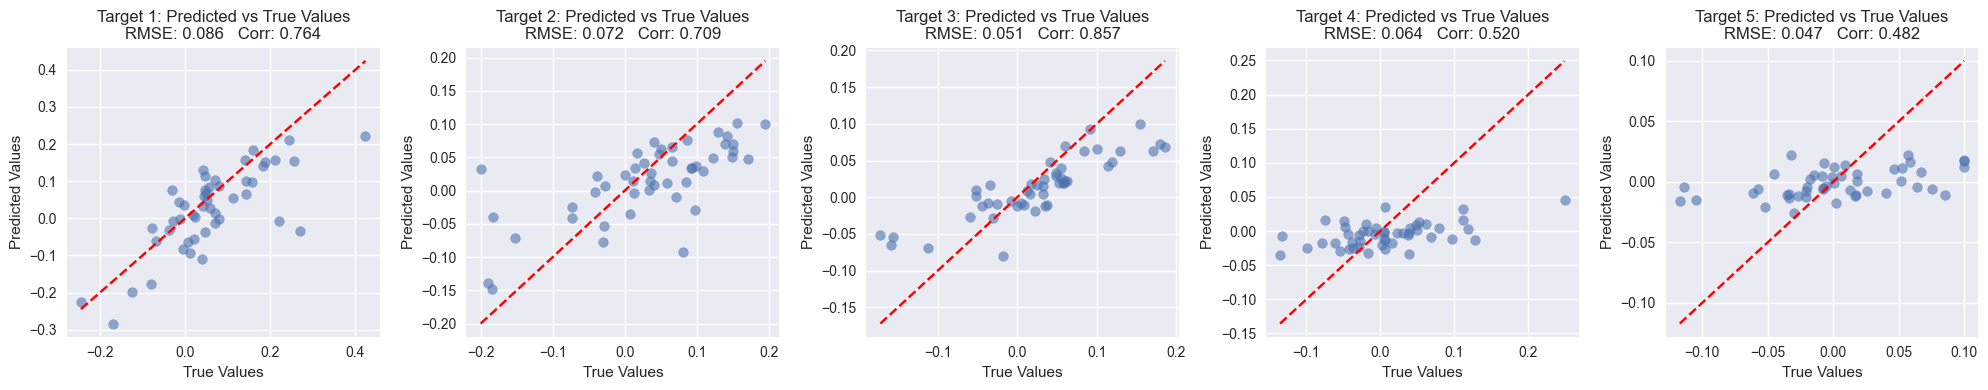

In [ ]:
# Model 16:  Plot predictions vs. true values
plot_predictions_vs_true(y_true = y_test_reduced_A2, 
                         y_pred = y_pred_test_A2_y_red, 
                         rmse_scores_test = rmse_scores_test_A2_y_red,
                         corr_target_test = corr_target_test_A2_y_red)

# Model 16: global correlation plot of the model's predictions with all points and a correlation line.
plot_correlation_model(y_true=y_test_reduced_A2, y_pred=y_pred_test_A2_y_red, overall_corr_coeff=overall_corr_test_A2_y_red)

# Model 12: y_test_reduced_A2, y_pred_test_A2_y_red
plot_last_session_mean_prediction_vs_mean_true(y_true=y_test_reduced_A2, 
                                               y_pred=y_pred_test_A2_y_red, 
                                               overall_rmse = overall_rmse_test_A2_y_red,
                                               overall_corr = overall_corr_test_A2_y_red, 
                                               overall_r2 = overall_R2_test_A2_y_red,
                                               overall_adj_r2 = overall_adj_R2_test_A2_y_red,
                                               time_points = n_components_y, # PCA retained only 5 components
                                               x_ticks = 1)

#### Volver al espacio de características original

In [ ]:
# Inverse transform the predictions to the original target variable space: 
    # use y_pred_test_A2_y_red since we want to transform the model predictions back to the original space.
y_pred_original_space_yred = pca_y_A2.inverse_transform(y_pred_test_A2_y_red)  # Inverse PCA transformation

#### OPTION 2: 
# This formula takes the reduced predictions y_pred_test_A2_y_red (which were obtained using PCA-transformed target variables), 
# applies the inverse transformation using the PCA components, and adds back the mean value (if you had centered the data before PCA) 
# to obtain the predictions in the original target variable space.
# y_pred_original_space_yred = np.dot(y_pred_test_A2_y_red, pca_y_A2.components_) + pca_y_A2.mean_
#### OPTION 3: 
# y_pred_original_space_yred = np.dot(y_pred_test_A2_y_red[:,:n_components_y], 
#                                     pca_y_A2.components_[:n_components_y,:]) + pca_y_A2.mean_

In [ ]:
def evaluate_predicted_original_space(y_test_original, y_pred_original_space):
    """
    Evaluates the predicted values in the original space.
    Evaluates the performance of the predictions after transforming them back to the original feature space.
    
    By using this function with the original test target values y_test_A2 and the predictions in the original 
    feature space predicted_original_space_y_red, we can assess the performance of our multiple linear regression model 
    after transforming the reduced predictions back to the original space. These evaluation metrics will help us understand 
    how well the model performs on the original target variables.

    Parameters:
        y_test_original (np.ndarray): True test target data with shape (num_samples, num_targets).
        y_pred_original_space (np.ndarray): Predicted target values in the original space with shape (num_samples, num_targets).

    Returns:
        List[float]: List of root mean square error (RMSE) scores for each target variable.
        float: Overall root mean square error (RMSE) score averaged across all target variables.
        List[float]: List of correlation coefficients (Pearson's r) for each target variable.
        float: Overall correlation coefficient (Pearson's r) across all target variables.
        List[float]: List of coefficient of determination (R-squared) for each target variable.
        float: Overall coefficient of determination (R-squared) across all target variables.
        List[float]: List of adjusted R-squared for each target variable.
        float: Overall adjusted R-squared across all target variables.

    Notes:
        - This function evaluates the performance of the predicted values in the original space.
        - The provided y_test_original and y_pred_original_space should have the same shape.
        - The function returns the overall RMSE score, RMSE scores for each target variable, 
          correlation coefficients for each target variable, the overall correlation coefficient, 
          coefficients of determination for each target variable, overall coefficient of determination, 
          adjusted R-squared for each target variable, overall adjusted R-squared

    Example:
        rmse_scores_test, overall_rmse, correlation_coeffs, overall_corr_coeff, coeff_determination, 
        overall_coeff_determination, overall_adj_r_squared = evaluate_predicted_original_space(
            y_test_original, 
            y_pred_original_space)
    """
    num_targets = y_test_original.shape[1]
    rmse_scores_test = []
    correlation_coeffs = []
    coeff_determination_r2 = []
    adj_r_squared = []

    for i in range(num_targets):
        y_test_single = y_test_original[:, i]
        y_pred_single = y_pred_original_space[:, i]

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(y_test_single, y_pred_single))
        rmse_scores_test.append(rmse)

        # Calculate correlation coefficient (Pearson's r)
        corr_coeff, _ = pearsonr(y_test_single, y_pred_single)
        correlation_coeffs.append(corr_coeff)

        # Calculate coefficient of determination (R-squared)
        r2 = r2_score(y_test_single, y_pred_single)
        coeff_determination_r2.append(r2)

        # Calculate adjusted R-squared
        n = len(y_test_single)  # number of samples
        p = 1  # number of predictors (only one, the predicted value itself)
        adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))  # formula of adjusted R-squared
        adj_r_squared.append(adj_r2)

    # Calculate overall RMSE
    overall_rmse = mean_squared_error(y_test_original, y_pred_original_space, squared=False)
    # Calculate overall correlation coefficient
    overall_corr_coeff, _ = pearsonr(y_test_original.flatten(), y_pred_original_space.flatten())
    # Calculate overall coefficient of determination  (R-squared)
    overall_coeff_determination_r2 = r2_score(y_test_original, y_pred_original_space)
    # Calculate overall adjusted R-squared
    overall_adj_r_squared = 1 - (
            (1 - overall_coeff_determination_r2) * (len(y_test_original.flatten()) - 1) / (
            len(y_test_original.flatten()) - 1 - 1))

    return rmse_scores_test, overall_rmse, correlation_coeffs, overall_corr_coeff, coeff_determination_r2, \
           overall_coeff_determination_r2, overall_adj_r_squared

In [ ]:
# Model 16:
rmse_scores_test_original_y_red, overall_rmse_original_y_red, correlation_coeffs_original_y_red, overall_corr_coeff_original_y_red, \
coeff_determination_r2_original_y_red, overall_coeff_determination_r2_original_y_red, \
overall_adj_r_squared_original_y_red = evaluate_predicted_original_space(y_test_original = y_test_A2, 
                                                                         y_pred_original_space = y_pred_original_space_yred) 

In [ ]:
# Model 16: Plot predictions vs. true values
plot_predictions_vs_true(y_true = y_test_A2, 
                         y_pred = y_pred_original_space_yred, 
                         rmse_scores_test = rmse_scores_test_original_y_red,
                         corr_target_test = correlation_coeffs_original_y_red)

# Model 16: global correlation plot of the model's predictions with all points and a correlation line.
plot_correlation_model(y_true=y_test_A2, y_pred=y_pred_original_space_yred, overall_corr_coeff=overall_corr_coeff_original_y_red)

# Model 16: 
plot_last_session_mean_prediction_vs_mean_true(y_true = y_test_A2, 
                                               y_pred = y_pred_original_space_yred,
                                               overall_rmse = overall_rmse_original_y_red,
                                               overall_corr = overall_corr_coeff_original_y_red, 
                                               overall_r2 = overall_coeff_determination_r2_original_y_red,
                                               overall_adj_r2 = overall_adj_r_squared_original_y_red,
                                               time_points = 101,
                                               x_ticks = 10)
# Model 16: 
plot_system_output(hc_means = calculate_HC_mean(group = 'A', num_sessions = 2), 
                   first_session = X_test_A2, # X sin reducir
                   y_true = y_test_A2, 
                   y_pred = y_pred_original_space_yred,
                   overall_rmse = overall_rmse_original_y_red,
                   overall_corr = overall_corr_coeff_original_y_red, 
                   overall_r2 = overall_coeff_determination_r2_original_y_red,
                   overall_adj_r2 = overall_adj_r_squared_original_y_red,
                   time_points = 101,
                   text_x = 0.8,
                   text_y = 0.31)

# Model 16: plot last session mean prediction with RMSE color encoding
plot_last_session_mean_prediction_with_rmse(y_true=y_test_A2, 
                                            y_pred=y_pred_original_space_yred, 
                                            rmse_scores_test=rmse_scores_test_original_y_red)
                                            
# Model 16: plot last session mean prediction with correlation coefficient color encoding
plot_last_session_mean_prediction_with_corr(y_true=y_test_A2, 
                                            y_pred=y_pred_original_space_yred, 
                                            corr_target_test=correlation_coeffs_original_y_red)

# Model 16: plot last session mean prediction with R-squared color encoding
plot_last_session_mean_prediction_with_r2(y_true=y_test_A2, 
                                          y_pred=y_pred_original_space_yred, 
                                          r_squared=coeff_determination_r2_original_y_red)

## Model 17: XGBoost Regressor con PCA de la X (reducida) y de la Y (reducida)

### PCA de la X y PCA de la Y

In [ ]:
# Apply PCA to reduce the dimensionality of X_train_A2 and X_test_A2
X_train_reduced_A2, X_test_reduced_A2, loadings_A2_X_red, n_components_x = apply_pca_to_X(
                                                                df_train = combined_legs_2sessions_A_train,
                                                                X_train = X_train_A2, 
                                                                X_test = X_test_A2, 
                                                                variance_retained = 0.9)

# Apply PCA to reduce the dimensionality of y_train_A2 and y_test_A2
y_train_reduced_A2, y_test_reduced_A2, loadings_A2_y_red, n_components_y, pca_y_A2 = apply_pca_to_y(
                                                                df_train = combined_legs_2sessions_A_train,
                                                                y_train =  y_train_A2, 
                                                                y_test =  y_test_A2, 
                                                                variance_retained = 0.90)

### Training 

In [ ]:
# Train and evaluate the XGBoost Regressor (model 17) con PCA de la X (reducida) y PCA de la Y (reducida) 
model_results_A2_Xy_red, rmse_scores_A2_Xy_red, r2_scores_A2_Xy_red, corr_scores_A2_Xy_red = train_and_evaluate_xgboost(X_train=X_train_reduced_A2, 
                                                                                                                              y_train=y_train_reduced_A2)

Best Hyperparameters: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}
Results on Training Set:
 RMSE: 0.073
 R2 Score: 0.404
 Correlation coefficient: 0.765


### Evaluation

In [ ]:
# XGBoost Regressor (model 17) con PCA de la X (reducida) y PCA de la Y (reducida) evaluation on the test set
rmse_scores_test_A2_Xy_red, overall_rmse_test_A2_Xy_red, corr_target_test_A2_Xy_red, \
overall_corr_test_A2_Xy_red, R2_target_test_A2_Xy_red, overall_R2_test_A2_Xy_red, \
overall_adj_R2_test_A2_Xy_red, y_pred_test_A2_Xy_red = evaluate_model_on_test_set(model=model_results_A2_Xy_red, 
                                                                                  X_test=X_test_reduced_A2, 
                                                                                  y_test=y_test_reduced_A2)
print("Results on Test Set:")
print(f" Overall RMSE: {overall_rmse_test_A2_Xy_red:.3f}")
print(f" Overall Correlation Coefficient: {overall_corr_test_A2_Xy_red:.3f}")
print(f" Overall R-squared: {overall_R2_test_A2_Xy_red:.3f}")
print(f" Overall Adjusted R-squared: {overall_adj_R2_test_A2_Xy_red:.3f}")


Results on Test Set:
 Overall RMSE: 0.061
 Overall Correlation Coefficient: 0.727
 Overall R-squared: 0.419
 Overall Adjusted R-squared: 0.412


In [ ]:
# Model 17: Plot predictions vs. true values
plot_predictions_vs_true(y_true = y_test_reduced_A2, 
                         y_pred = y_pred_test_A2_Xy_red, 
                         rmse_scores_test = rmse_scores_test_A2_Xy_red,
                         corr_target_test = corr_target_test_A2_Xy_red)

# Model 17: global correlation plot of the model's predictions with all points and a correlation line.
plot_correlation_model(y_true=y_test_reduced_A2, y_pred=y_pred_test_A2_Xy_red, overall_corr_coeff=overall_corr_test_A2_Xy_red)

# Model 17: y_test_reduced_A2, y_pred_test_A2_y_red
plot_last_session_mean_prediction_vs_mean_true(y_true=y_test_reduced_A2, 
                                               y_pred=y_pred_test_A2_Xy_red,
                                               overall_rmse = overall_rmse_test_A2_Xy_red,
                                               overall_corr = overall_corr_test_A2_Xy_red,
                                               time_points = n_components_y, # PCA retained only 5 components
                                               overall_r2 = overall_R2_test_A2_Xy_red,
                                               overall_adj_r2 = overall_adj_R2_test_A2_Xy_red,
                                               x_ticks = 1)

#### Volver al espacio de características original

In [ ]:
# Inverse transform the predictions to the original target variable space: 
    # use y_pred_test_A2_y_red since we want to transform the model predictions back to the original space.
y_pred_original_space_Xyred = pca_y_A2.inverse_transform(y_pred_test_A2_Xy_red)  # Inverse PCA transformation

#### OPTION 2: 
# This formula takes the reduced predictions y_pred_test_A2_Xy_red (which were obtained using PCA-transformed target variables), 
# applies the inverse transformation using the PCA components, and adds back the mean value (if you had centered the data before PCA) 
# to obtain the predictions in the original target variable space.
# y_pred_original_space_Xyred = np.dot(y_pred_test_A2_Xy_red, pca_y_A2.components_) + pca_y_A2.mean_
#### OPTION 3: 
# y_pred_original_space_Xyred = np.dot(y_pred_test_A2_Xy_red[:,:n_components_y], 
#                                      pca_y_A2.components_[:n_components_y,:]) + pca_y_A2.mean_

In [ ]:
# Model 17: XGBoost Regressor
rmse_scores_test_original_Xy_red, overall_rmse_original_Xy_red, correlation_coeffs_original_Xy_red, overall_corr_coeff_original_Xy_red, \
coeff_determination_r2_original_Xy_red, overall_coeff_determination_r2_original_Xy_red, \
overall_adj_r_squared_original_Xy_red = evaluate_predicted_original_space(y_test_original = y_test_A2, 
                                                                          y_pred_original_space = y_pred_original_space_Xyred)

In [ ]:
# Model 17: Plot predictions vs. true values
plot_predictions_vs_true(y_true = y_test_A2, 
                         y_pred = y_pred_original_space_Xyred, 
                         rmse_scores_test = rmse_scores_test_original_Xy_red,
                         corr_target_test = correlation_coeffs_original_Xy_red)

# Model 17: global correlation plot of the model's predictions with all points and a correlation line.
plot_correlation_model(y_true=y_test_A2, y_pred=y_pred_original_space_Xyred, overall_corr_coeff=overall_corr_coeff_original_Xy_red)

# Model 17:
plot_last_session_mean_prediction_vs_mean_true(y_true = y_test_A2, 
                                               y_pred = y_pred_original_space_Xyred, 
                                               overall_rmse = overall_rmse_original_Xy_red,
                                               overall_corr = overall_corr_coeff_original_Xy_red, 
                                               overall_r2 = overall_coeff_determination_r2_original_Xy_red,
                                               overall_adj_r2 = overall_adj_r_squared_original_Xy_red,
                                               time_points = 101,
                                               x_ticks = 10)
                                               
# Model 17:
plot_system_output(hc_means = calculate_HC_mean(group = 'A', num_sessions = 2), 
                   first_session = X_test_A2, # X sin reducir
                   y_true = y_test_A2, 
                   y_pred = y_pred_original_space_Xyred,
                   overall_rmse = overall_rmse_original_Xy_red,
                   overall_corr = overall_corr_coeff_original_Xy_red, 
                   overall_r2 = overall_coeff_determination_r2_original_Xy_red,
                   overall_adj_r2 = overall_adj_r_squared_original_Xy_red,
                   time_points = 101)

# Model 17: plot last session mean prediction with RMSE color encoding
plot_last_session_mean_prediction_with_rmse(y_true=y_test_A2, 
                                            y_pred=y_pred_original_space_Xyred, 
                                            rmse_scores_test=rmse_scores_test_original_Xy_red)

# Model 17: plot last session mean prediction with correlation coefficient color encoding
plot_last_session_mean_prediction_with_corr(y_true=y_test_A2, 
                                            y_pred=y_pred_original_space_Xyred, 
                                            corr_target_test=correlation_coeffs_original_Xy_red)

# Model 17: plot last session mean prediction with R-squared color encoding
plot_last_session_mean_prediction_with_r2(y_true=y_test_A2, 
                                          y_pred=y_pred_original_space_Xyred, 
                                          r_squared=coeff_determination_r2_original_Xy_red)

## RMSE y R-squared de cada modelo de XGBoost Regressor

In [ ]:
print('RMSE')
print(rmse_scores_test_A2)
print(rmse_scores_test_A2_X_red)
print(rmse_scores_test_original_y_red)
print(rmse_scores_test_original_Xy_red)
print('\n')
print('R2')
print(R2_target_test_A2)
print(R2_target_test_A2_X_red)
print(coeff_determination_r2_original_y_red)
print(coeff_determination_r2_original_Xy_red)